# Directional semivariograms

## Table of Contents:

1. Read point data,
2. Create directional and isotropic semivariograms,
3. Compare semivariograms.

## Level: Basic

## Changelog

| Date | Change description | Author |
|------|--------------------|--------|
| 2022-09-22 | The first version of tutorial | @SimonMolinsky |

## Introduction

In this tutorial, we will learn about directional semivariograms, how to set the angle of `direction` and what's the `tolerance` parameter.

Not every spatial process may be described by isotropic semivariograms. Sometimes we see a specific trend in one direction (N-S, W-E, or NE-SW, NW-SE). A well performed analysis includes directions, that's why we will learn how to write a code in `pyinterpolate` that retrieves the directional variogram.

We use the air pollution data downloaded with the package.

> **Note**: if you you are a machine learning enthusiast it will be easier for you to understand **direction** as an additional feature used to model semivariance.

## Import packages

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# IO - read text
from pyinterpolate import download_air_quality_poland
# Experimental variogram
from pyinterpolate import build_experimental_variogram
# Theoretical Variogram
from pyinterpolate import TheoreticalVariogram, build_theoretical_variogram

## 1) Read and show point data

In [2]:
DATASET = 'PM2.5'

# This block is commented intentionally.
# You may uncomment the last line and download a new dataset, but there is a high chance that you'll obtain
# a different results! To be sure, that results are the same, use data stored in the
# 'samples/directional_variogram_PM25_20220922.csv' file. See next cell.

# ds = download_air_quality_poland(DATASET)

In [3]:
ds = pd.read_csv('samples/directional_variogram_PM25_20220922.csv', index_col='station_id')
ds.head()

,y,x,PM2.5
station_id,,,
659,50.529892,22.112467,7.12765
736,54.380279,18.620274,4.66432
861,54.167847,19.410942,3.00739
266,51.259431,22.569133,7.10000
355,51.856692,19.421231,2.00000


In [4]:
def df2gdf(df, lon_col='x', lat_col='y', epsg=4326, crs=None):
    """
    Function transforms DataFrame into GeoDataFrame.
    
    Parameters
    ----------
    df : pandas DataFrame
    
    lon_col : str, default = 'x'
        Longitude column name.
        
    lat_col : str, default = 'y'
        Latitude column name.
        
    epsg : Union[int, str], default = 4326
        EPSG number of projection.
        
    crs : str, default = None
        Coordinate Reference System of data.
        
    Returns
    -------
    gdf : GeoPandas GeoDataFrame
        GeoDataFrame with set geometry column ('geometry'), CRS, and all columns from the passed DataFrame.
    
    """
    
    gdf = gpd.GeoDataFrame(df)
    gdf['geometry'] = gpd.points_from_xy(x=df[lon_col], y=df[lat_col])
    gdf.geometry = gdf['geometry']
    
    if crs is None:
        gdf.set_crs(epsg=epsg, inplace=True)
    else:
        gdf.set_crs(crs=crs, inplace=True)
        
    return gdf

In [5]:
gds = df2gdf(ds)
gds.head()

,y,x,PM2.5,geometry
station_id,,,,
659,50.529892,22.112467,7.12765,POINT (22.11247 50.52989)
736,54.380279,18.620274,4.66432,POINT (18.62027 54.38028)
861,54.167847,19.410942,3.00739,POINT (19.41094 54.16785)
266,51.259431,22.569133,7.10000,POINT (22.56913 51.25943)
355,51.856692,19.421231,2.00000,POINT (19.42123 51.85669)


In [6]:
gds.isna().any()

y           False
x           False
PM2.5        True
geometry    False
dtype: bool

In [7]:
gds = gds.dropna(axis=0)

Text(0.5, 1.0, 'PM2.5 concentrations in Poland')

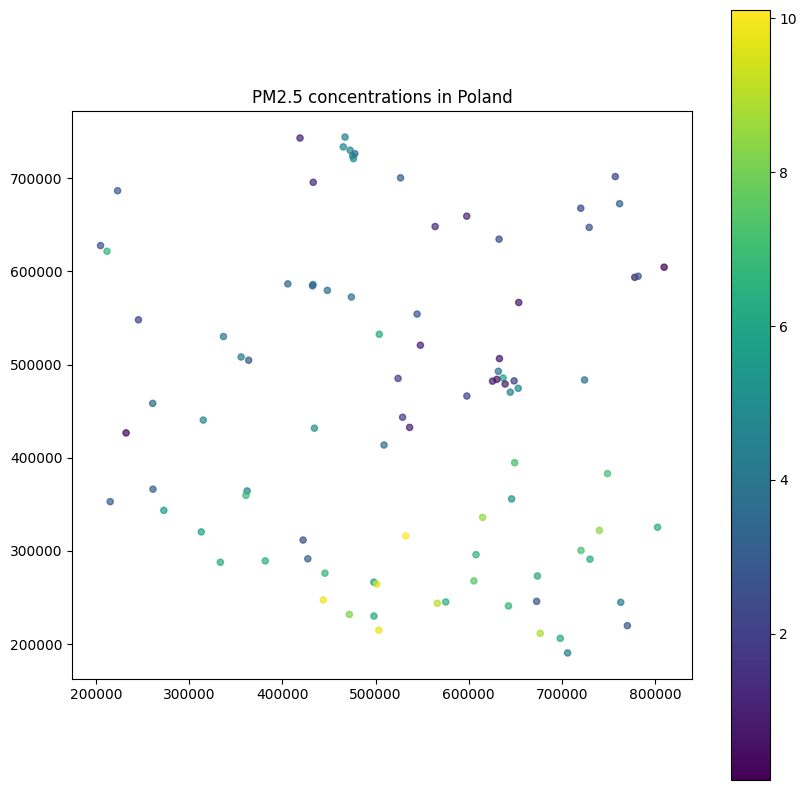

In [8]:
gds = gds.to_crs(epsg=2180)
gds.plot(figsize=(10, 10), column=DATASET, legend=True, markersize=20, alpha=0.7)
plt.title('PM2.5 concentrations in Poland')

## 2) Create the experimental semivariogram

If we recall the tutorial `Semivariogram Estimation`, there are three main parameters to set for the `build_experimental_variogram()` function:

1. `input_array`: `numpy array` with coordinates and observed values, for example `[[0, 0, 10], [0, 1, 20]]`,
2. `step_size`: we must divide our area of analysis into discrete **lags**. **Lags** are intervals (usually circular) within which we check if the point has a neighbor. For example, if we look into the lag `500`, then we are going to compare one point with other points in a distance `(0, 1000]` from this point,
3. `max_range`: it is a tricky one, and it is hard to guess it at the first try. This parameter represents the possible **maximum range of spatial dependency**. This parameter shouldn't exceed half of the extent.

But that's not everything!

We didn't use two other parameters:

4. `direction`: it is a `float` in range [0, 360]. We set the direction of semivariogram:
    * 0 or 180: is NS direction,
    * 90 or 270 is EW direction,
    * 45 or 225 is NE-SW direction,
    * 135 or 315 is NW-SE direction.

5. `tolerance`: it is a `float` in range [0, 1]. If we leave `tolerance` with default **1**, we will always get isotropic semivariogram. Other edge case is if we set `tolerance` to **0**, then points must be placed on a single line with the beginning in the origin of the coordinate system and the angle given by y axis and direction parameter. If tolerance is > 0 and < 1 then the bin is selected as an elliptical area with major axis pointed in the same direction as the line for 0 tolerance.
    * The major axis size is `(tolerance * step_size)`,
    * The minor axis size is `((1 - tolerance) * step_size)`,
    * The baseline point is at a center of the ellipse.
    
The best idea is to visualize it on a cartesian plane:

<img src="imgs/dir_semi_tutorial_graphics.jpg" alt="The visualization of directional variogram calculation" style="max-width: 800px;"/>

* The top plane shows a unit circle that is the omnidirectional variogram (black circle). Within it we see two ellipses: one is bright-green and another is dark green.
* The bottom plane also shows a unit circle and two ellipses. The brighter yellow, and darker purple ellipse.
* The long arrows within both circles are radiuses of the omnidirectional variogram or **the semi-major axis** of a directional ellipse. It's length is controlled by the `step_size` parameter. The short arrows are present only in the **directional variograms** and they are **the semi-minor axes**. Their length is controlled by `tolerance` parameter and it is always:
  - a fraction of `step_size`,
  - **1**, in this case a semivariogram is omnidirectional,
  - a value very close to 0 (but not 0) - in this case ellipse falls into a line.
* The good idea is to set `tolerance` to 0.5 and then gradually make it smaller or larger (it depends on the spatial features).

Now, when we understand how our parameters affect semivariogram bins range, we can start analysis. We will set `tolerance` to 0.2 in each case to better visualize the effects of a leading direction.

### Case 1: N-S Direction

In [9]:
BIN_RADIUS = 60000  # meters
MAX_RANGE = 400000  # meters
TOLERANCE = 0.2

In [10]:
inp_arr = np.array(list(zip(gds['geometry'].x,
                            gds['geometry'].y,
                            gds[DATASET])))

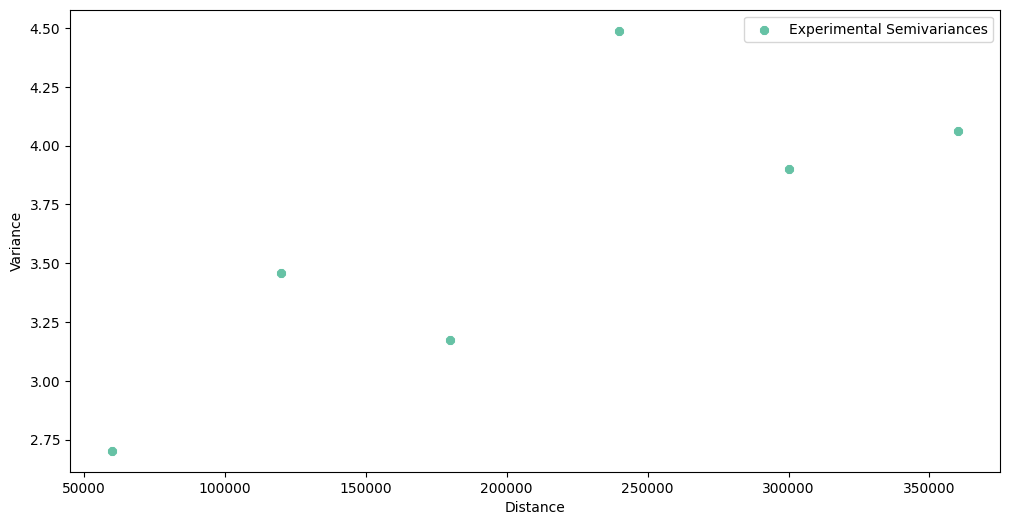

In [11]:
ns_variogram = build_experimental_variogram(
    input_array=inp_arr,
    step_size=BIN_RADIUS,
    max_range=MAX_RANGE,
    direction=0,
    tolerance=TOLERANCE
)

ns_variogram.plot(plot_semivariance=True)

### Case 2: W-E Direction

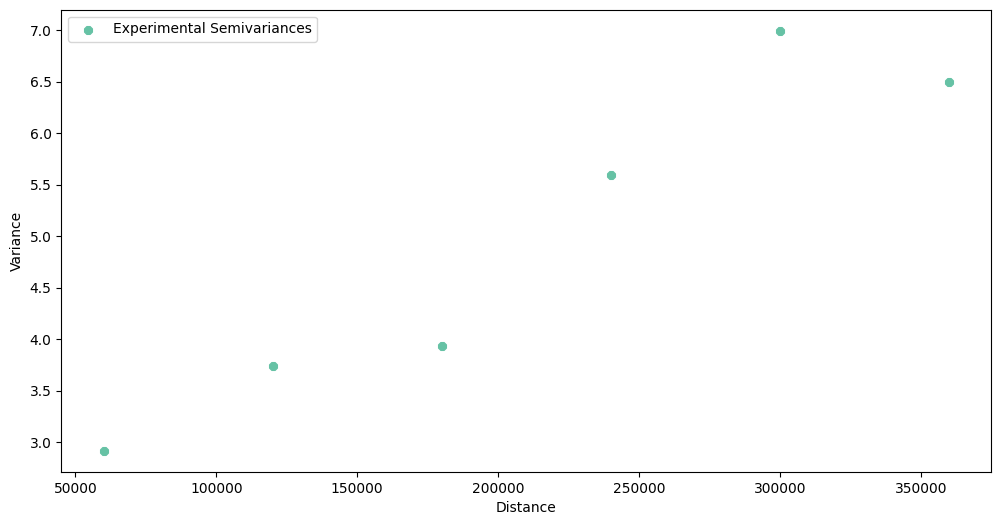

In [12]:
we_variogram = build_experimental_variogram(
    input_array=inp_arr,
    step_size=BIN_RADIUS,
    max_range=MAX_RANGE,
    direction=90,
    tolerance=TOLERANCE
)

we_variogram.plot(plot_semivariance=True)

### Case 3: NE-SW Direction

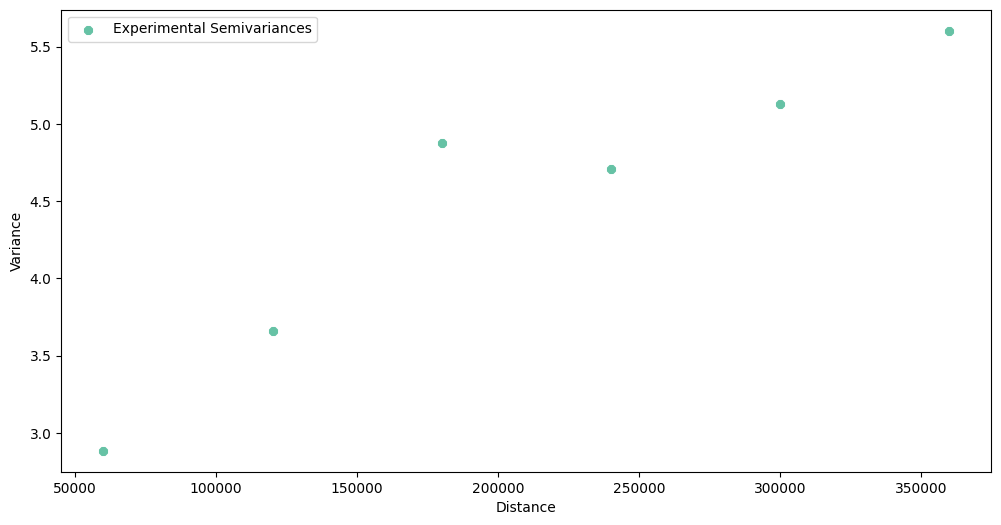

In [13]:
ne_sw_variogram = build_experimental_variogram(
    input_array=inp_arr,
    step_size=BIN_RADIUS,
    max_range=MAX_RANGE,
    direction=45,
    tolerance=TOLERANCE
)

ne_sw_variogram.plot(plot_semivariance=True)

### Case 4: NW-SE Direction

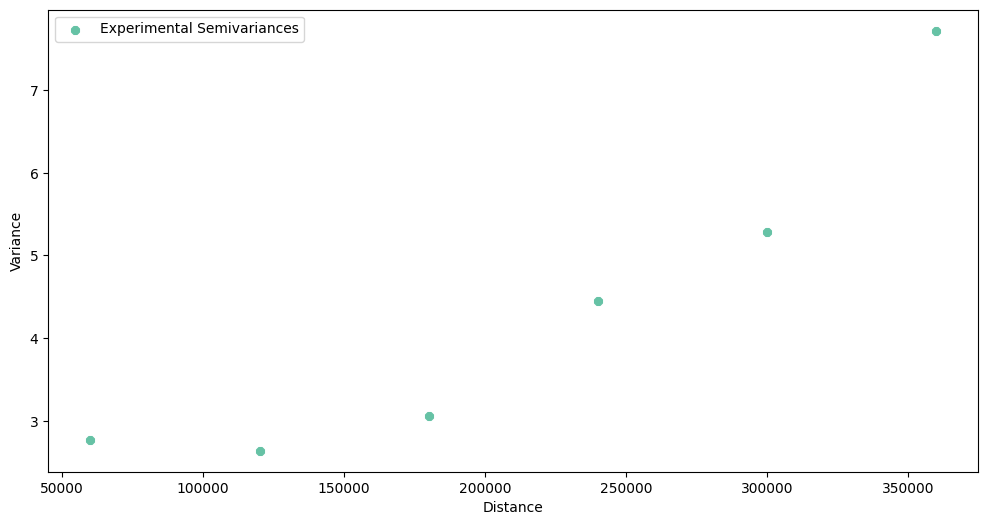

In [14]:
nw_se_variogram = build_experimental_variogram(
    input_array=inp_arr,
    step_size=BIN_RADIUS,
    max_range=MAX_RANGE,
    direction=135,
    tolerance=TOLERANCE
)

nw_se_variogram.plot(plot_semivariance=True)

### Case 5: Isotropic Variogram

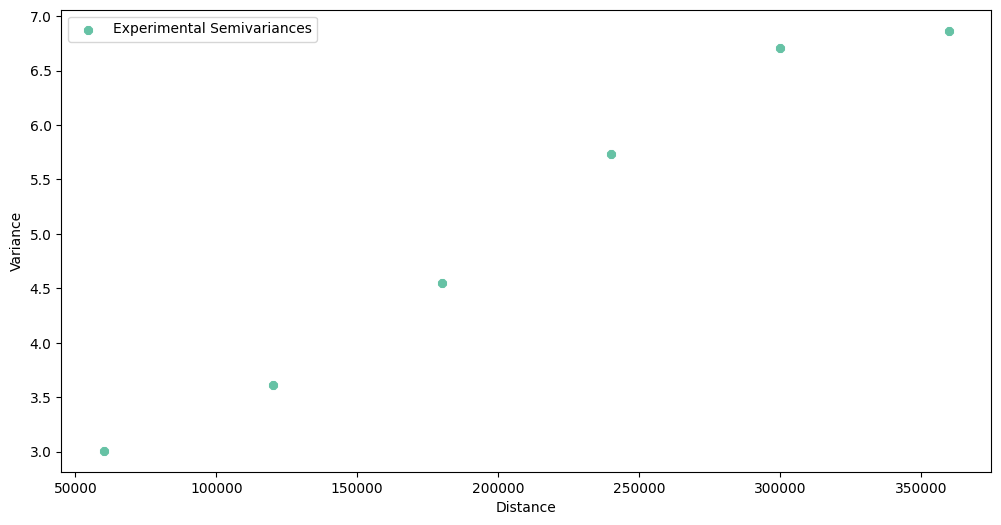

In [15]:
iso_variogram = build_experimental_variogram(
    input_array=inp_arr,
    step_size=BIN_RADIUS,
    max_range=MAX_RANGE
)

iso_variogram.plot()

## 3) Compare semivariograms

We have created a set of variograms. What did we observe?

- The **NW-SE** variogram is very weak at describing a short-range variation (compare it to the map of air pollution from the beginning of the tutorial. Points in this direction are rather similar).
- The **W-E** variogram seems to work well for a short range.
- The **N-S** variogram catches too much variability, lags are too short for this direction.
- The **NE-SW** variogram looks good, and shows approximately linear change of variability in a function of distance. It has the smallest variance from all variograms.

We can visualize and compare all variograms at once, that we are sure that the y-axis is the same for every plot.

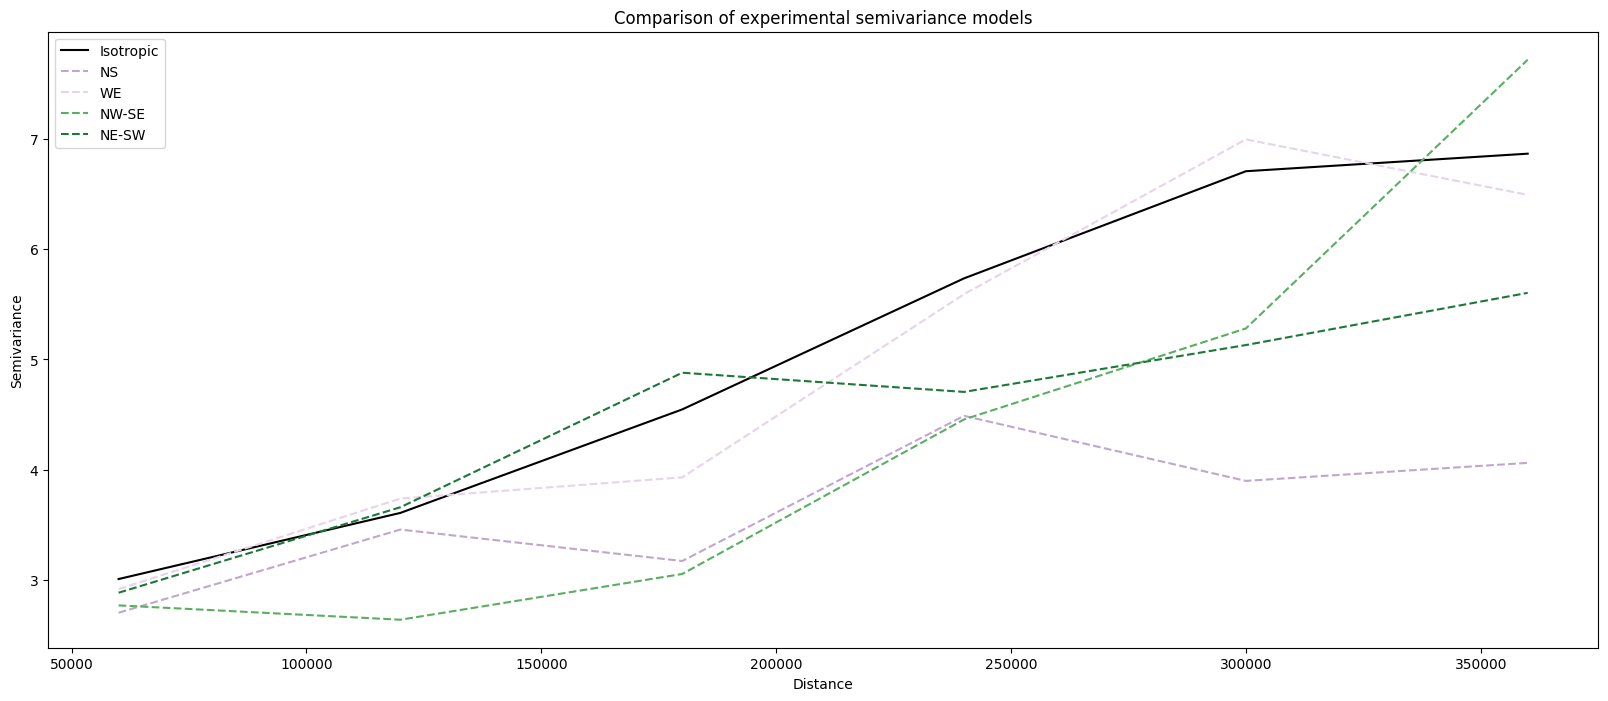

In [16]:
_lags = iso_variogram.lags
_ns = ns_variogram.experimental_semivariances
_we = we_variogram.experimental_semivariances
_nw_se = nw_se_variogram.experimental_semivariances
_ne_sw = ne_sw_variogram.experimental_semivariances
_iso = iso_variogram.experimental_semivariances

plt.figure(figsize=(20, 8))
plt.plot(_lags, _iso, color='black')
plt.plot(_lags, _ns, '--', color='#c2a5cf')
plt.plot(_lags, _we, '--', color='#e7d4e8')
plt.plot(_lags, _nw_se, '--', color='#5aae61')
plt.plot(_lags, _ne_sw, '--', color='#1b7837')
plt.title('Comparison of experimental semivariance models')
plt.legend(['Isotropic',
            'NS',
            'WE',
            'NW-SE',
            'NE-SW'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

What do you think about this comparison? Do you agree, that the **NE-SW** variogram is the best fit for a data?